In [5]:
import pandas as pd
import numpy as np
import glob, os, subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import palettable
import matplotlib
from sklearn.metrics.pairwise import cosine_similarity

matplotlib.rcParams["font.family"] = 'arial'

OUTPUT_DIR = "/data/project/Alzheimer/YSscript/cle/Revision/3.BioData_dissim_signature"
if os.path.exists(OUTPUT_DIR) == False:
    os.system("mkdir -p " + OUTPUT_DIR)

In [16]:
df_total_count  = pd.DataFrame()
decision_dict = {}

import palettable
sns.set_style("white")

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors
Pastel_10 = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
Antique_10 = palettable.cartocolors.qualitative.Antique_10.mpl_colors


# # General
# fig_total_raw, ax_total_raw = plt.subplots(nrows = 9, ncols = 10, figsize = (25, 20))
# fig_total_raw.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.95, left = 0.05, right = 0.95)
# fig_total_raw.suptitle ( "TOTAL_raw" , fontsize = 30, y = 0.98, fontweight = "semibold")
# sns.despine(  left=True, right=True, top=True, bottom=True )

# fig_total_clone, ax_total_clone = plt.subplots(nrows = 9, ncols = 10, figsize = (25, 20))
# fig_total_clone.subplots_adjust (wspace = 0.05, hspace = 0.03, bottom = 0.02, top = 0.95, left = 0.05, right = 0.95)
# fig_total_clone.suptitle ( "TOTAL_clone" , fontsize = 30, y = 0.98, fontweight = "semibold")
# sns.despine(  left=True, right=True, top=True, bottom=True )



DIR = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/2.woMosaic_ver1"        # AG : 3.woMosaic_ver2
DONOR_LIST = [i.split("/")[-1] for i in sorted(glob.glob(DIR + "/*")) ]
n = 0
n_monoclonal = 0
n_hard = 0

for DONOR in DONOR_LIST:               # PD42566
    TISSUE_LIST = sorted( glob.glob (DIR + "/" + DONOR + "/*") ) 
    TISSUE_LIST = [i.split("/")[-1] for i in TISSUE_LIST]

    #for TISSUE in TISSUE_LIST:               # colon_crypt, pancreas_islet
    for TISSUE in [ "bronchus_epithelium", "liver_parenchyma" ]:
        SAMPLE_LIST = sorted ( glob.glob (DIR + "/" + DONOR + "/" + TISSUE + "/*") ) 
        SAMPLE_LIST = [i.split("/")[-1].split(".")[0] for i in SAMPLE_LIST]

        for SAMPLE in SAMPLE_LIST:       # PD42566b_lo00_A7.txt
            SAMPLENAME = SAMPLE.split("_")[0]
            INPUT_TSV = DIR + "/" + DONOR + "/" + TISSUE + "/" + SAMPLE + ".txt"

            COMBINED_OUTPUT_DIR = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            NPVAF_DIR = "/data/project/Alzheimer/CLEMENT/02.npvaf/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            CLEMENT_DIR = "/data/project/Alzheimer/YSscript/cle/data/CLEMENT/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            # PYCLONEVI_DIR = "/data/project/Alzheimer/YSscript/cle/data/pyclone-vi/3.BioData/Moore_1D/" + TISSUE  + "/" + DONOR + "-" + SAMPLENAME
            # SCICLONE_DIR = "/data/project/Alzheimer/YSscript/cle/data/sciclone/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
            # QUANTUMCLONE_DIR = "/data/project/Alzheimer/YSscript/cle/data/quantumclone/3.BioData/Moore_1D/" + TISSUE  + "/" + DONOR + "-" + SAMPLENAME
            
            # 없다면 (CLEMENT error) 그냥 넘어가자
            if os.path.exists( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt" ) == False:   
                continue
            if not os.path.exists ( CLEMENT_DIR + "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt" ):    # 없다면 (CLEMENT error) 그냥 넘어가자
                continue
            # monoclonal은 집에 가라
            result_df = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.results.txt", sep = "\t", header = None, index_col = 0)
            if result_df.loc["NUM_CHILD"][1] == "1":    
                n_monoclonal += 1
                continue



            # Hard, Soft clustering 붙이기
            with open( COMBINED_OUTPUT_DIR  + "/CLEMENT_decision.evidence.txt", 'r') as file:
                decision = "Hard" if "hard" in file.readline().rstrip() else "Soft"
                if decision == "Hard":
                    n_hard +=1
            decision_dict [TISSUE + "_" + SAMPLENAME] = decision

            #print ( "{}\t{}\t{}\t{}".format( DONOR, TISSUE, SAMPLENAME, decision) ) 

            # Signature(SBS) profile 불러오기
            signature_df = pd.read_csv ( CLEMENT_DIR+ "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt", sep = "\t")
            cosine_sim1 = cosine_similarity(signature_df.iloc[:, 1:signature_df.shape[1] ])   # k개 clone의 similarity를 분석
            break
            print ( cosine_sim1[cosine_sim1.shape[1] - 1, :], "\n")
            if cosine_sim1.shape[1] > 2:
                for s in cosine_sim1[cosine_sim1.shape[1] - 1, :-1]:
                    sim_df = sim_df.append ( pd.DataFrame ( [ {"cosi_sim" : s, "tool" : "CLEMENT" } ] ) , ignore_index = True)
            break






            #################################################
            # ax_row, ax_col = int(n / 10), n % 10

            # df_total = pd.read_csv ( COMBINED_OUTPUT_DIR + "/0.input_containpos.txt", sep = "\t", names = ["pos", "tissue", "depthalt", "cha1", "cha2"] ).drop(["cha1", "cha2" ], axis=1)
            # df_total = calc_vaf (df_total, "depthalt", SAMPLENAME)

            # df_total_membership = pd.read_csv ( COMBINED_OUTPUT_DIR + "/result/CLEMENT_decision.membership.txt", header = None, names = ["clone"])

            # df_total = pd.concat ( [df_total, df_total_membership], axis = 1)



In [17]:
cosine_sim1

array([[1.        , 0.99653657, 0.99931569],
       [0.99653657, 1.        , 0.99892987],
       [0.99931569, 0.99892987, 1.        ]])

In [14]:
signature_df

,Samples,SBS1,SBS2,SBS4,SBS5,SBS7a,SBS7b,SBS7c,SBS7d,SBS10a,...,SBS10d,SBS13,SBS16,SBS17a,SBS17b,SBS18,SBS32,SBS35,SBS40,SBS91
0,0,0,0,90,260,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6,0,99,226,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,whole,6,0,188,487,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
import pandas as pd
import numpy as np
import glob, os, subprocess
from tqdm import tqdm

######## Moore VCF
Moore_VCF = pd.read_csv("/data/project/Alzheimer/CLEMENT/resource/paper/whole_info.polyphen.sift.alpha.txt", sep = "\t")

# column을 소문자로 바꾸기
Moore_VCF.rename(columns=lambda x: x.lower(), inplace=True)

# lexicographically 정렬하기
custom_order = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "X", "Y"]
Moore_VCF['chr_categorical'] = pd.Categorical(Moore_VCF['chr'], categories=custom_order, ordered=True)
Moore_VCF = Moore_VCF.sort_values(by= ['chr_categorical', 'start']).reset_index(drop=True).drop ("chr_categorical", axis = 1)

# 앞에 "chr" 붙여주기
Moore_VCF["pos"]  = "chr" + Moore_VCF["chr"] + "_" + Moore_VCF["start"].astype("str")
Moore_VCF["refalt"] =  Moore_VCF["ref"] + "/" + Moore_VCF["alt"]
Moore_VCF["gene_single"] = Moore_VCF['gene'].str.split(',')
print (Moore_VCF.shape)




(518444, 19)


In [94]:
class ResultClass:
    def __init__(self):
        self.membership = np.array ([])
        #self. = pd.DataFrame ( columns = range(5)  )


kwargs = {}

CLEMENT = ResultClass()
kwargs ["INPUT_TSV"] = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/bronchus_epithelium/PD28690-A8/0.input_containpos.txt"
kwargs ["CLEMENT_MEMBERSHIP"] = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/bronchus_epithelium/PD28690-A8/result/CLEMENT_decision.membership.txt"
kwargs ["CLEMENT_MEMBERSHIP"] = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/bronchus_epithelium/PD28690-A8/CLEMENT_hard_1st.membership.txt"
#kwargs ["CLEMENT_MIXTURE"] = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/bronchus_epithelium/PD28690-G9/result/CLEMENT_decision.mixture.txt"

CLEMENT.membership = np.array ( pd.read_csv (kwargs["CLEMENT_MEMBERSHIP"], header = None ).iloc[:, 0] )
INPUT_CONTAINPOS = pd.read_csv (kwargs["INPUT_TSV"], header = None, sep = "\t" )

In [95]:
df = pd.merge ( INPUT_CONTAINPOS, Moore_VCF, left_on = 0, right_on = "pos" ).drop_duplicates( ["pos"]).reset_index(drop = True)
if df.shape[0] == len (CLEMENT.membership):
    df2 = pd.merge (df, pd.DataFrame (CLEMENT.membership), left_index = True, right_index = True)
    print (df2.shape)
else:
    print ("길이가 다르다. Moore_VCF = {}\tCLEMENT.membership = {}".format (df.shape, len(CLEMENT.membership)))

df2 = pd.DataFrame ( df2.groupby(["0_y"])["func"].value_counts() ).unstack(level='0_y').fillna (0).astype (int)
df2.columns = df2.columns.droplevel(0)   # drop 0st column ("func")
df2 = pd.concat ( [df2, df2.sum().to_frame().T], axis = 0)
df2.index  = df2.index[:-1].tolist() + ['total']

(1156, 25)


In [96]:
df2

0_y,0,1,2
UTR3,2,4,3
downstream,0,1,2
exonic,3,2,5
intergenic,221,307,190
intronic,119,153,106
ncRNA_exonic,1,2,1
ncRNA_intronic,6,14,7
upstream,0,4,2
upstream;downstream,0,1,0
total,352,488,316


In [ ]:

for k in tqdm ( range ( Moore_VCF.shape[0] ) ) :
    check = False
    for g in Moore_VCF.iloc[k]["gene_single"]:
        if ("OR" not in g)  & ("LOC" not in g) & ("NONE" not in g):
            check = True
            break
    if check == False:
        ii = [index for index, item in enumerate( Moore_VCF.iloc[k]["gene_single"] ) if 'LOC' in item]
        if len(ii) >= 1:
            g = Moore_VCF.iloc[k]["gene_single"][ii [0] ]
        else:
            g = "-"

    Moore_VCF.loc[k, "gene_single"] = g

    if k % 50000 == 0:
        print (k)
    #print (g , Moore_VCF.loc[k, "gene_single"])


Moore_VCF.to_csv ("/data/project/Alzheimer/CLEMENT/resource/paper/whole_info_singlegene.txt", sep = "\t", index = False)
Moore_VCF.loc[:, ["chr", "start", "end", "refalt", "depth_count", "alt_count", "vaf", "sample", "donorid", "tissue", "func", "gene_single"]].to_csv ("/data/project/Alzheimer/CLEMENT/resource/paper/whole_info.vepinput.txt", sep = "\t", index = False)

In [17]:
import pandas as pd
import numpy as np
import glob, os, re, subprocess
from sklearn.metrics.pairwise import cosine_similarity

def out(command): 
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True, shell=True) 
    return result.stdout.rstrip("\n")

def make_class(row):
    global df 

    if row['Samples'] == 'whole':
        return 'whole'
    elif row["Samples"] == str(df.shape[0] - 2):
        return 'bigger'
    else:
        return 'other'


def make_SBS1_proportion (signature_df, tool):
    global df 

    signature_df_melt = pd.melt ( signature_df, id_vars = ["Samples"],var_name = "SBS", value_name = "value")
    df =  pd.merge ( signature_df_melt [ signature_df_melt["SBS"] == "SBS1"] , signature_df_melt.groupby("Samples")["value"].sum(), left_on = "Samples", right_on = "Samples" )
    df ["SBS1_proportion"] = df["value_x"] / df["value_y"]
    df ["tool"] = tool
    df['class'] = df.apply(make_class, axis=1)
    return df

########################################################################################################################################################################


def Other_tissues ( ) :
    DIR = "/data/project/Alzheimer/CLEMENT/01.INPUT_TSV/3.BioData/Moore_1D/2.woMosaic_ver1"        # AG : 3.woMosaic_ver2
    DONOR_LIST = sorted(glob.glob(DIR + "/*"))
    DONOR_LIST = [i.split("/")[-1] for i in DONOR_LIST]
    n = 0

    long_df = pd.DataFrame ( columns = ["Samples", "SBS", "value_x", "value_y", "SBS1_proportion", "tool"] )
    sim_df = pd.DataFrame ( columns = ["cosi_sim", "tool"] )

    for DONOR in DONOR_LIST:               # PD42566
        TISSUE_LIST = sorted( glob.glob (DIR + "/" + DONOR + "/*") ) 
        TISSUE_LIST = [i.split("/")[-1] for i in TISSUE_LIST]

        #for TISSUE in TISSUE_LIST:               # colon_crypt, pancreas_islet
        for TISSUE in [ "liver_parenchyma" ]: # "bronchus_epithelium", 
            SAMPLE_LIST = sorted ( glob.glob (DIR + "/" + DONOR + "/" + TISSUE + "/*") ) 
            SAMPLE_LIST = [i.split("/")[-1].split(".")[0] for i in SAMPLE_LIST]

            for SAMPLE in SAMPLE_LIST:       # PD42566b_lo00_A7.txt
                INPUT_TSV = DIR + "/" + DONOR + "/" + TISSUE + "/" + SAMPLE + ".txt"
                
                kwargs = {"INPUT_TSV" : INPUT_TSV,  "MODE" : "Both",  "NUM_CLONE_TRIAL_START" : 1, "NUM_CLONE_TRIAL_END" : 5, 
                                "TRIAL_NO" : 10, "DEPTH_CUTOFF" : 10,  "KMEANS_CLUSTERNO" : 8, "MIN_CLUSTER_SIZE" : 5,  "MAKEONE_STRICT" :  3,
                                "RANDOM_PICK" : 0, "AXIS_RATIO":0, "PARENT_RATIO": 0, "NUM_PARENT" : 0,  "FP_RATIO":0,  "FP_USEALL" : "False", 
                                "RANDOM_SEED" : 0, "SAMPLENAME" : "", "BENCHMARK_NO" : 0, 
                                "NPVAF_DIR" : "", "SIMPLE_KMEANS_DIR" : "", "CLEMENT_DIR" : "", "SCICLONE_DIR" : "", "PYCLONEVI_DIR" : "",  "COMBINED_OUTPUT_DIR" : "",
                                "SCORING" : False,  "MAXIMUM_NUM_PARENT" : 1, "VERBOSE" : 1 }

                NUMBER_LINE = int(out ("wc -l  " + INPUT_TSV).split(" ")[0]) 

                if NUMBER_LINE < 350:       # 350줄이 안 되는 파일은 넘어간다
                    continue 
                # else:
                #     kwargs ["RANDOM_PICK"] = 300

                kwargs ["RANDOM_PICK"] = -1    # Select all

                kwargs["NUM_BLOCK_INPUT"] = kwargs["NUM_BLOCK"] = NUM_BLOCK = 1
                SAMPLENAME = kwargs["SAMPLENAME"] = re.split(r'[_ .]', INPUT_TSV.split("/")[-1])[0]

                
                kwargs["NPVAF_DIR"] = "/data/project/Alzheimer/CLEMENT/02.npvaf/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
                kwargs["COMBINED_OUTPUT_DIR"] = "/data/project/Alzheimer/CLEMENT/03.combinedoutput/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
                kwargs["SIMPLE_KMEANS_DIR"] = "/data/project/Alzheimer/YSscript/cle/data/SIMPLE_KMEANS/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
                kwargs["CLEMENT_DIR"] = "/data/project/Alzheimer/YSscript/cle/data/CLEMENT/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
                kwargs["PYCLONEVI_DIR"] = "/data/project/Alzheimer/YSscript/cle/data/pyclone-vi/3.BioData/Moore_1D/" + TISSUE  + "/" + DONOR + "-" + SAMPLENAME
                kwargs["SCICLONE_DIR"] = "/data/project/Alzheimer/YSscript/cle/data/sciclone/3.BioData/Moore_1D/" + TISSUE + "/" + DONOR + "-" + SAMPLENAME
                kwargs["QUANTUMCLONE_DIR"] = "/data/project/Alzheimer/YSscript/cle/data/quantumclone/3.BioData/Moore_1D/" + TISSUE  + "/" + DONOR + "-" + SAMPLENAME

                if not os.path.exists ( kwargs["CLEMENT_DIR"] + "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt" ):
                    continue

                print ( "{}_{}".format( TISSUE, SAMPLENAME) ) 

                signature_df = pd.read_csv ( kwargs["CLEMENT_DIR"] + "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt", sep = "\t")
                cosine_sim1 = cosine_similarity(signature_df.iloc[:, 1:signature_df.shape[1] ])
                #print ( cosine_sim1[cosine_sim1.shape[1] - 1, :], "\n")
                if cosine_sim1.shape[1] > 2:
                    for s in cosine_sim1[cosine_sim1.shape[1] - 1, :-1]:
                        sim_df = sim_df.append ( pd.DataFrame ( [ {"cosi_sim" : s, "tool" : "CLEMENT" } ] ) , ignore_index = True)

                signature_df = pd.read_csv ( kwargs["PYCLONEVI_DIR"] + "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt", sep = "\t")
                cosine_sim1 = cosine_similarity(signature_df.iloc[:, 1:signature_df.shape[1] ])
                if cosine_sim1.shape[1] > 2:
                    for s in cosine_sim1[cosine_sim1.shape[1] - 1, :-1]:
                        sim_df = sim_df.append ( pd.DataFrame ( [ {"cosi_sim" : s, "tool" : "pyclonevi" } ] ) , ignore_index = True)

                signature_df = pd.read_csv ( kwargs["SCICLONE_DIR"] + "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt", sep = "\t")
                cosine_sim1 = cosine_similarity(signature_df.iloc[:, 1:signature_df.shape[1] ])
                if cosine_sim1.shape[1] > 2:
                    for s in cosine_sim1[cosine_sim1.shape[1] - 1, :-1]:
                         sim_df = sim_df.append ( pd.DataFrame ( [ {"cosi_sim" : s, "tool" : "sciclone" } ] ) , ignore_index = True)

                signature_df = pd.read_csv ( kwargs["QUANTUMCLONE_DIR"] + "/SigProfiler/output/Assignment/Assignment_Solution/Activities/Assignment_Solution_Activities.txt", sep = "\t")
                cosine_sim1 = cosine_similarity(signature_df.iloc[:, 1:signature_df.shape[1] ])
                if cosine_sim1.shape[1] > 2:
                    for s in cosine_sim1[cosine_sim1.shape[1] - 1, :-1]:
                         sim_df = sim_df.append ( pd.DataFrame ( [ {"cosi_sim" : s, "tool" : "quantumclone" } ] ) , ignore_index = True)

                long_df = long_df.append( make_SBS1_proportion (signature_df, "CLEMENT") , ignore_index = True) 
    
    return sim_df
            
#     return long_df
                


# if __name__ == "__main__":
#     SCRIPT_DIR = os.getcwd()
#     print (SCRIPT_DIR, "\n")

sim_df = Other_tissues ()

liver_parenchyma_Z2
liver_parenchyma_E1
liver_parenchyma_F1
liver_parenchyma_G1
liver_parenchyma_H1


Text(0, 0.5, 'cosine similiarity')

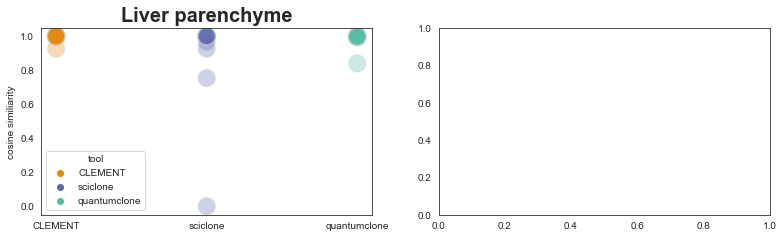

In [34]:
import matplotlib 
matplotlib.rcParams["font.family"] = 'arial'
import palettable
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors

colorlist = [i for i in safe7]
sns.set_style("white")
#sns.set_palette("tab10")
sns.set_palette(sns.color_palette(colorlist))

fig, ax = plt.subplots( nrows = 1, ncols = 2, figsize = (11, 4))
fig.subplots_adjust ( hspace = 0.25, bottom = 0.15, top = 0.8, left = 0.06, right = 0.98)

sns.scatterplot ( sim_df, x = "tool", y = "cosi_sim", hue = "tool",  edgecolor = Gr_10[3], alpha = 0.3, s = 300, ax = ax[0])
ax[0].set_title ("Liver parenchyme", fontsize = 20, fontweight = "semibold")
ax[0].set_xlabel ("")
ax[0].set_ylabel ("cosine similiarity")

In [28]:
colorlist

[(0.8980392156862745, 0.5254901960784314, 0.023529411764705882),
 (0.36470588235294116, 0.4117647058823529, 0.6941176470588235),
 (0.3215686274509804, 0.7372549019607844, 0.6392156862745098),
 (0.6, 0.788235294117647, 0.27058823529411763),
 (0.8, 0.3803921568627451, 0.6901960784313725),
 (0.1411764705882353, 0.4745098039215686, 0.4235294117647059),
 (0.8549019607843137, 0.6470588235294118, 0.10588235294117647),
 (0.1843137254901961, 0.5411764705882353, 0.7686274509803922),
 (0.4627450980392157, 0.3058823529411765, 0.6235294117647059),
 (0.9294117647058824, 0.39215686274509803, 0.35294117647058826)]

In [56]:
# Remove columns with all zeros
signature_df_filtered = signature_df.loc[:, (signature_df != 0).any()]
signature_df_filtered

,Samples,SBS1,SBS5
0,0,11,567
1,1,54,534
2,whole,65,1101


In [59]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim1 = cosine_similarity(signature_df.iloc[:, 1:signature_df.shape[1] ])
cosine_sim2 = cosine_similarity(signature_df_filtered.iloc[:, 1:signature_df_filtered.shape[1] ])
print (cosine_sim1)
print (cosine_sim2)

[[1.         0.99669022 0.99921718]
 [0.99669022 1.         0.999126  ]
 [0.99921718 0.999126   1.        ]]
[[1.         0.99669022 0.99921718]
 [0.99669022 1.         0.999126  ]
 [0.99921718 0.999126   1.        ]]


<Axes: xlabel='class', ylabel='SBS1_proportion'>

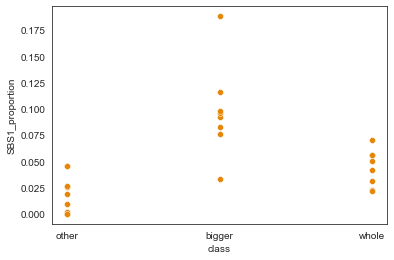

In [50]:
import matplotlib 
matplotlib.rcParams["font.family"] = 'arial'
import palettable
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

tabl = palettable.tableau.Tableau_20.mpl_colors
safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors

colorlist = [i for i in safe7]
sns.set_style("white")
#sns.set_palette("tab10")
sns.set_palette(sns.color_palette(colorlist))

sns.scatterplot ( long_df , x = "class", y = "SBS1_proportion")

In [25]:
df [df ["Samples"] == "1"]

df.groupby("Samples")["value"].sum()

Samples
0         578
1         588
whole    1166
Name: value, dtype: int64

In [33]:
pd.merge ( df [ df["SBS"] == "SBS1"] , df.groupby("Samples")["value"].sum(), left_on = "Samples", right_on = "Samples" )

,Samples,SBS,value_x,value_y
0,0,SBS1,11,578
1,1,SBS1,54,588
2,whole,SBS1,65,1166
